In [1]:
periodo = 'pre-pandemia'

# Importe as bibliotecas necessárias

In [2]:
%matplotlib inline
from IPython.display import clear_output
import tqdm
import os
import pandas as pd
import numpy as np
import seaborn as sns
import random
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree._classes import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors._classification import KNeighborsClassifier
from sklearn.neural_network._multilayer_perceptron import MLPClassifier
from sklearn.linear_model._logistic import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
#from yellowbrick.style.colors import resolve_colors
from sklearn.model_selection._validation import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from unidecode import unidecode
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.decomposition import PCA
import pickle
#import statsmodels.api as sm
import platform 
np.random.seed(42)

In [3]:
def strfdelta(tdelta, fmt="{hours}:{minutes}:{seconds}"):
    d = {"days": tdelta.days}
    d["hours"], rem = divmod(tdelta.seconds, 3600)
    d["minutes"], d["seconds"] = divmod(rem, 60)
    return fmt.format(**d)

In [4]:
def limparTela():
    
    plt = platform.system()
    
    if plt == "Windows":
        clear = lambda: os.system('cls')
        clear()
    elif plt == "Linux":
        print("Your system is Linux")
        clear = lambda: os.system('clear')
        clear()
    else:
        print("Unidentified system")

# Carregando Base de dados

In [5]:
df = pd.read_csv(f'twitterbase_{periodo}.csv', sep=';')
df.head()

,volumeTweets_media,volumeTweets_variancia,volumeTweets_mediaMovelPonterada,volumeTweets_entropia,indiceInsonia_media,indiceInsonia_variancia,indiceInsonia_mediaMovelPonterada,indiceInsonia_entropia,pronome1Pessoa_media,pronome1Pessoa_variancia,...,links_entropia,midia_media,midia_variancia,midia_mediaMovelPonterada,midia_entropia,curtidas_media,curtidas_variancia,curtidas_mediaMovelPonterada,curtidas_entropia,classe
0,0.232915,0.315346,1.605634,0.593198,0.086239,0.111151,0.578638,0.307958,0.016736,0.022035,...,0.324054,0.006974,0.006925,0.049296,0.041577,0.103208,0.179027,0.725352,0.320571,depressao
1,2.510294,47.111659,17.270431,1.838695,0.620732,1.595054,4.288012,1.377158,0.483824,3.058562,...,0.159815,0.000000,0.000000,0.000000,0.000000,1.048529,5.416763,7.237741,1.303106,depressao
2,0.356322,1.985678,2.425234,0.612006,0.146022,0.323983,1.003827,0.443252,0.112644,0.251679,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002299,0.002294,0.002336,0.016263,controle
3,0.154891,0.891770,1.027701,0.334143,0.034081,0.039944,0.243190,0.160835,0.008152,0.013520,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,1.033288,0.891967,0.183438,controle
4,30.116279,1931.916712,206.861111,2.842062,2.232019,15.639582,16.762029,2.242101,10.953488,269.858302,...,2.348284,0.441860,1.176852,3.388889,0.795581,4.023256,75.557599,25.500000,1.857342,depressao


# Codificando a variável categórica

In [6]:
label_encoder = LabelEncoder()
df['classe'] = label_encoder.fit_transform(df['classe']).astype('float64')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71232 entries, 0 to 71231
Data columns (total 61 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   volumeTweets_media                              71232 non-null  float64
 1   volumeTweets_variancia                          71232 non-null  float64
 2   volumeTweets_mediaMovelPonterada                71232 non-null  float64
 3   volumeTweets_entropia                           71232 non-null  float64
 4   indiceInsonia_media                             71232 non-null  float64
 5   indiceInsonia_variancia                         71232 non-null  float64
 6   indiceInsonia_mediaMovelPonterada               71232 non-null  float64
 7   indiceInsonia_entropia                          71232 non-null  float64
 8   pronome1Pessoa_media                            71232 non-null  float64
 9   pronome1Pessoa_variancia               

# Preparando os dados

In [8]:
def train_val_test(X, y, train_ratio, val_ratio, test_ratio):
    assert sum([train_ratio, test_ratio, val_ratio])==1.0, "wrong given ratio, all ratios have to sum to 1.0"
    assert X.shape[0]==len(y), "X and y shape mismatch"

    ind_train = int(round(X.shape[0]*train_ratio))
    ind_test = int(round(X.shape[0]*(train_ratio+test_ratio)))

    X_train = X[:ind_train]
    X_test = X[ind_train:ind_test]
    X_val = X[ind_test:]

    y_train = y[:ind_train]
    y_test = y[ind_train:ind_test]
    y_val = y[ind_test:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
def plotarMatrizesConfusoes(nome_classificador, matriz_confusao_relativa):
    plt.figure(figsize=(10, 8))
    plt.title(f'Matriz de confusão {nome_classificador}')
    sns.heatmap(matriz_confusao_relativa, linewidths=.5, cmap='coolwarm', annot=True, fmt='.1%', vmin=0, vmax=1,
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.savefig(f'matrizConfusao_{nome_classificador}_{periodo}.png', bbox_inches='tight', format="png")
    plt.show()
    plt.close()

In [10]:


def avaliacao(classificador, predicao, x, y, nome_classificador):
    '''
    Computa as mericas de avaliação dos clasficadores
    '''
        
    precisao = precision_score(y, predicao)
    revocacao = recall_score(y, predicao)
    f1score = f1_score(y, predicao)
    acuracia = accuracy_score(y, predicao)
    return [precisao, revocacao, f1score, acuracia]
    
def modeloML(model, x, x_train, y_train, x_val, y_val, nome_classificador):
    clear_output()
    print(nome_classificador)
    
    model.fit(x_train, y_train)
    predicao = cross_val_predict(model, x_val, y_val, cv=cv)
    #predicao = GridSearchCV(model, {}, cv=cv, verbose=10, n_jobs=3).fit(x_train, y_train).predict(x_val)
    #predicao = cross_val_predict(GridSearchCV(model, {}, cv=cv, verbose=10).fit(x_train, y_train).best_estimator_, x_val, y_val, cv=cv)
    resultados = avaliacao(model, predicao, x_val, y_val, nome_classificador)
    df_resultados.loc[nome_classificador][f'exp_teste_precisao'] = round(resultados[0] * 100, 1)
    df_resultados.loc[nome_classificador][f'exp_teste_recall'] = round(resultados[1] * 100, 1)
    df_resultados.loc[nome_classificador][f'exp_teste_f1_score'] = round(resultados[2] * 100, 1)
    df_resultados.loc[nome_classificador][f'exp_teste_acuracia'] = round(resultados[3] * 100, 1)
    
    
def modeloMLTeste(model, x, x_train, y_train, x_val, y_val, nome_classificador):
    clear_output()
    print(nome_classificador)
    
    predicao = cross_val_predict(model, x_val, y_val, cv=cv)
    #predicao = GridSearchCV(model, {}, cv=cv, verbose=10, n_jobs=3).fit(x_train, y_train).predict(x_val)
    #predicao = cross_val_predict(GridSearchCV(model, {}, cv=cv, verbose=10).fit(x_train, y_train).best_estimator_, x_val, y_val, cv=cv)
    resultados = avaliacao(model, predicao, x_val, y_val, nome_classificador)
    df_resultados.loc[nome_classificador][f'exp_teste_precisao'] = round(resultados[0] * 100, 1)
    df_resultados.loc[nome_classificador][f'exp_teste_recall'] = round(resultados[1] * 100, 1)
    df_resultados.loc[nome_classificador][f'exp_teste_f1_score'] = round(resultados[2] * 100, 1)
    df_resultados.loc[nome_classificador][f'exp_teste_acuracia'] = round(resultados[3] * 100, 1)
    
    matriz_confusao = confusion_matrix(y_val, predicao)
    matriz_confusao_relativa = matriz_confusao / matriz_confusao.sum(axis=1, keepdims=True)
    
    plotarMatrizesConfusoes(nome_classificador, matriz_confusao_relativa)

In [11]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
zscore = StandardScaler()

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

In [12]:
if not os.path.exists(f'df_resultados_{periodo}_novosAtributos_teste_f1Score.xlsx'):
    metricas = ['acuracia', 'precisao', 'recall', 'f1_score']
    colunas = [f'exp_teste_{i}' for i in metricas]
    #metricas = [f'{metrica} Exp {numero}' for numero in range(1, 2) for metrica in metricas]
    modelos = ['Gradient Boosting', 'Perceptron Multicamadas']
    df_resultados = pd.DataFrame(columns=colunas, index=modelos)
    df_resultados.index.name = "Model"
else:
    df_resultados = pd.read_excel(f'df_resultados_{periodo}_novosAtributos_teste_f1Score.xlsx', index_col=0)
    

In [13]:
df_resultados

,exp_teste_acuracia,exp_teste_precisao,exp_teste_recall,exp_teste_f1_score
Model,,,,
Gradient Boosting,76.8,75.5,88.9,81.6
Perceptron Multicamadas,75.8,75.4,86.5,80.6


In [14]:
def executar(x, y):

    x_train, y_train, x_val, y_val, x_test, y_test = train_val_test(x, y, train_ratio, validation_ratio, test_ratio)
    
    gradientBoosting = GradientBoostingClassifier(random_state=42, n_estimators=100, verbose=10)
    perceptronMulticamadas = MLPClassifier(random_state=42, hidden_layer_sizes=(10,30,10), max_iter=100, verbose=10)
    
    modeloML(perceptronMulticamadas, x, x_train, y_train, x_val, y_val, 'Perceptron Multicamadas')
    modeloML(gradientBoosting, x, x_train, y_train, x_val, y_val, 'Gradient Boosting')
    
    modeloMLTeste(perceptronMulticamadas, x, x_train, y_train, x_test, y_test, 'Perceptron Multicamadas')
    modeloMLTeste(gradientBoosting, x, x_train, y_train, x_test, y_test, 'Gradient Boosting')

In [15]:
choq = ['volumeTweets_media', 'volumeTweets_mediaMovelPonterada', 
        'indiceInsonia_variancia', 'indiceInsonia_mediaMovelPonterada',
        'pronome1Pessoa_media', 'pronome1Pessoa_variancia', 
        'pronome2Pessoa_mediaMovelPonterada', 'pronome2Pessoa_entropia',
        'pronome3Pessoa_media', 'pronome3Pessoa_mediaMovelPonterada',
        'valencia_mediaMovelPonterada', 'valencia_entropia', 
        'ativacao_mediaMovelPonterada', 'ativacao_entropia', 
        'termosDepressivos_variancia', 'termosDepressivos_mediaMovelPonterada',
        'grafoSocial_variancia', 'grafoSocial_mediaMovelPonterada',
        'medicamentosAntiDepressivo_media', 'medicamentosAntiDepressivo_mediaMovelPonterada']
caracteresOrientais = ['caracteresOrientais_variancia', 'caracteresOrientais_mediaMovelPonterada']
emojis = ['emojis_variancia', 'emojis_entropia']
links = ['links_mediaMovelPonterada', 'links_entropia']
midia = ['midia_variancia', 'midia_mediaMovelPonterada']
curtidas = ['curtidas_media', 'curtidas_mediaMovelPonterada']

In [16]:
#gb
exp = choq# + caracteresOrientais + midia + emojis + curtidas + links

exp

['volumeTweets_media',
 'volumeTweets_mediaMovelPonterada',
 'indiceInsonia_variancia',
 'indiceInsonia_mediaMovelPonterada',
 'pronome1Pessoa_media',
 'pronome1Pessoa_variancia',
 'pronome2Pessoa_mediaMovelPonterada',
 'pronome2Pessoa_entropia',
 'pronome3Pessoa_media',
 'pronome3Pessoa_mediaMovelPonterada',
 'valencia_mediaMovelPonterada',
 'valencia_entropia',
 'ativacao_mediaMovelPonterada',
 'ativacao_entropia',
 'termosDepressivos_variancia',
 'termosDepressivos_mediaMovelPonterada',
 'grafoSocial_variancia',
 'grafoSocial_mediaMovelPonterada',
 'medicamentosAntiDepressivo_media',
 'medicamentosAntiDepressivo_mediaMovelPonterada']

Gradient Boosting
      Iter       Train Loss   Remaining Time 
         1           1.3100            6.93s
         2           1.2689            6.09s
         3           1.2340            6.58s
         4           1.2058            6.17s
         5           1.1817            6.07s
         6           1.1605            6.23s
         7           1.1432            6.21s
         8           1.1274            6.01s
         9           1.1134            5.92s
        10           1.1009            5.97s
        11           1.0903            5.92s
        12           1.0810            5.79s
        13           1.0720            5.70s
        14           1.0646            6.06s
        15           1.0576            5.99s
        16           1.0512            5.88s
        17           1.0449            5.95s
        18           1.0394            5.88s
        19           1.0343            5.84s
        20           1.0297            5.77s
        21           1.0244         

        83           0.9197            1.14s
        84           0.9184            1.08s
        85           0.9175            1.01s
        86           0.9163            0.94s
        87           0.9153            0.87s
        88           0.9144            0.81s
        89           0.9138            0.74s
        90           0.9128            0.67s
        91           0.9120            0.61s
        92           0.9106            0.54s
        93           0.9098            0.47s
        94           0.9092            0.40s
        95           0.9084            0.34s
        96           0.9080            0.27s
        97           0.9069            0.20s
        98           0.9063            0.13s
        99           0.9050            0.07s
       100           0.9039            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.3085            7.11s
         2           1.2654            6.15s
         3           1.2307            6.59s
         

        64           0.9394            2.40s
        65           0.9380            2.34s
        66           0.9372            2.28s
        67           0.9363            2.21s
        68           0.9349            2.14s
        69           0.9338            2.08s
        70           0.9327            2.01s
        71           0.9307            1.94s
        72           0.9297            1.87s
        73           0.9293            1.81s
        74           0.9279            1.74s
        75           0.9271            1.67s
        76           0.9259            1.61s
        77           0.9250            1.54s
        78           0.9237            1.47s
        79           0.9224            1.41s
        80           0.9213            1.34s
        81           0.9209            1.27s
        82           0.9201            1.21s
        83           0.9192            1.14s
        84           0.9180            1.07s
        85           0.9169            1.00s
        86

        45           0.9603            4.73s
        46           0.9587            4.61s
        47           0.9573            4.52s
        48           0.9557            4.43s
        49           0.9540            4.31s
        50           0.9523            4.22s
        51           0.9514            4.12s
        52           0.9503            4.03s
        53           0.9483            3.92s
        54           0.9470            3.84s
        55           0.9458            3.74s
        56           0.9448            3.65s
        57           0.9431            3.55s
        58           0.9426            3.47s
        59           0.9413            3.37s
        60           0.9405            3.28s
        61           0.9390            3.19s
        62           0.9380            3.10s
        63           0.9361            3.01s
        64           0.9358            2.92s
        65           0.9341            2.83s
        66           0.9328            2.74s
        67

        28           0.9935            4.92s
        29           0.9911            4.82s
        30           0.9887            4.78s
        31           0.9864            4.69s
        32           0.9845            4.64s
        33           0.9817            4.56s
        34           0.9794            4.48s
        35           0.9773            4.44s
        36           0.9756            4.36s
        37           0.9737            4.31s
        38           0.9722            4.24s
        39           0.9709            4.17s
        40           0.9686            4.10s
        41           0.9670            4.02s
        42           0.9654            3.96s
        43           0.9644            3.91s
        44           0.9626            3.83s
        45           0.9613            3.77s
        46           0.9603            3.70s
        47           0.9585            3.62s
        48           0.9572            3.57s
        49           0.9564            3.50s
        50

        10           1.0969            6.05s
        11           1.0860            5.93s
        12           1.0769            5.94s
        13           1.0678            5.91s
        14           1.0600            5.83s
        15           1.0534            5.73s
        16           1.0466            5.64s
        17           1.0410            5.61s
        18           1.0359            5.52s
        19           1.0307            5.50s
        20           1.0269            5.44s
        21           1.0225            5.32s
        22           1.0193            5.29s
        23           1.0154            5.21s
        24           1.0118            5.17s
        25           1.0077            5.09s
        26           1.0043            5.00s
        27           1.0012            4.92s
        28           0.9989            4.88s
        29           0.9966            4.80s
        30           0.9942            4.72s
        31           0.9915            4.68s
        32

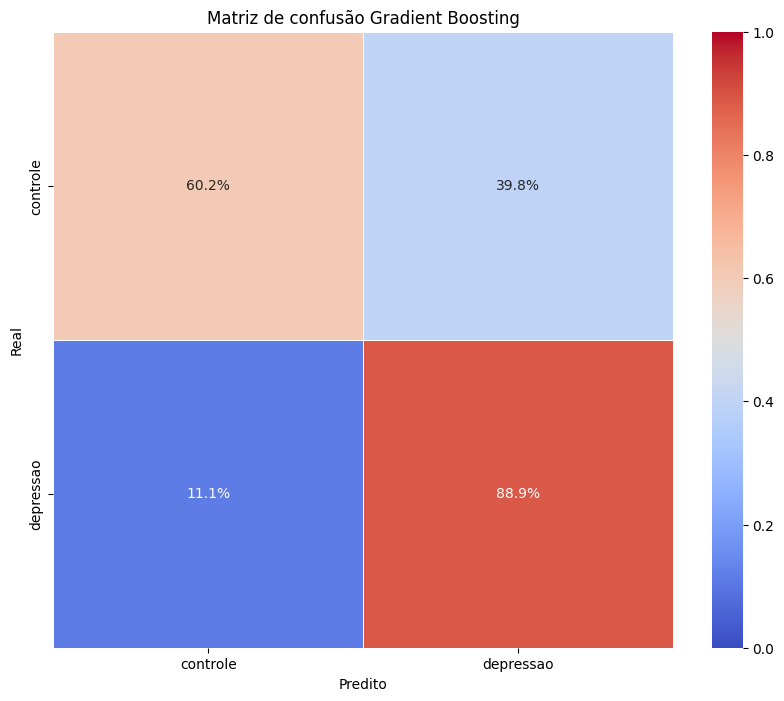

In [17]:
x = df[exp].copy()
y = df['classe'].copy()
    #selectKBest = SelectKBest(chi2, k=int(x.shape[1] * 0.5)).fit(x, y)
    #x_new = selectKBest.transform(x)
x_new = zscore.fit_transform(x)
    #x = PCA(n_components=0.95, svd_solver='full', random_state=42).fit_transform(x)

    
executar(x_new, y)

df_resultados_round = df_resultados.copy()
#df_resultados_round.to_excel(f'df_resultados_{periodo}_novosAtributos_teste_f1Score.xlsx', encoding='utf-8')

In [18]:
#df_resultados_round